In [1]:
# This section enables to use the module code referenced in the repo
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
# Imports for the excercise
import pandas as pd 
import logging
import numpy as np
from arcus.azureml.environment.environment_factory import WorkEnvironmentFactory as fac

from sklearn.model_selection import train_test_split
from sklearn import linear_model


## Connecting to a remote AzureML environment

In [8]:
azure_config_file = '../.azureml/config.json'
work_env = fac.Create(connected=True, datastore_path='arcus_partition_test', config_file=azure_config_file)


Connected to AzureML workspace
>> Name: codit-ai-incubators-ml
>> Subscription: c1537527-c126-428d-8f72-1ac9f2c63c1f
>> Resource group: codit-ai-incubators


## Loading a partitioned dataframe

In [17]:
partition_df = work_env.load_tabular_partition('test-partitioning/stock_AT*', columns=['Close', 'High', 'Isin', 'ItemDate', 'Low', 'Market', 'Open', 'Ticker', 'Volume'])

In [18]:
partition_df.tail(5)

,Close,High,Isin,ItemDate,Low,Market,Open,Ticker,Volume
25,17.96,17.96,ATFREQUENT09,2019-05-30 14:44:26,17.80,XETR,17.9,FQT,5844
26,18.06,18.06,ATFREQUENT09,2019-05-31 17:35:37,17.80,XETR,17.9,FQT,13868
27,17.94,18.16,ATFREQUENT09,2019-06-03 17:35:45,17.80,XETR,18.0,FQT,9125
28,17.90,17.90,ATFREQUENT09,2019-06-04 15:24:47,17.72,XETR,17.8,FQT,5256
29,17.96,18.00,ATFREQUENT09,2019-06-05 12:48:15,17.80,XETR,17.8,FQT,2069


In [19]:
df = work_env.load_tabular_dataset('smart-devops-changesets')
df.head(5)

,DefinitionId,DefinitionName,DefinitionQueueStatus,DefinitionType,BuildId,BuildFinishTime,BuildQueueTime,BuildStartTime,BuildResult,BuildStatus,BuildRepositoryType,ChangeSetId,ChangeSetCheckedInBy,ChangeSetCreatedDate,ChangeSetChangeFile,ChangeSetChangeChangeType
2019-12-20 09:30:43,177,Sgbdnl.Portal,enabled,build,31966,2019-12-20 09:51:47,2019-12-20 09:30:43,2019-12-20 09:46:48,succeeded,completed,TfsGit,1e3f0533f4a473cae0a8f86ff6a749532e091021,Rgvgt Igttkvugp,2019-12-20 09:30:42,GalvanoSendOrderB2BRequestHandlerTests.cs,edit
2019-11-06 11:39:45,177,Sgbdnl.Portal,enabled,build,30448,2019-11-06 11:51:52,2019-11-06 11:39:45,2019-11-06 11:39:55,succeeded,completed,TfsGit,c1218a2988f8d4086a923398da4f0548b61ea5ea,Rgvgt Igttkvugp,2019-11-06 11:39:44,InvoiceRepositoryTests.cs,edit
2020-03-24 12:25:34,177,Sgbdnl.Portal,enabled,build,35542,2020-03-24 12:43:40,2020-03-24 12:25:34,2020-03-24 12:43:40,canceled,completed,TfsGit,60d289d4e5bd148fd0490b97f666102d5d437142,Ulqtu xcp Quej,2020-03-24 12:25:33,Sgbdnl.Ebusiness.SalesOrder.Api.csproj,edit
2020-02-05 11:13:15,177,Sgbdnl.Portal,enabled,build,33474,2020-02-05 11:15:31,2020-02-05 11:13:15,2020-02-05 11:13:18,succeeded,completed,TfsGit,1ca8690ebc1ec53458e5e94aa0783cb2e76c07c5,Lqjcp Qquvgtjqnv,2020-02-05 11:12:23,BannerProfile.cs,edit
2019-12-12 08:57:48,177,Sgbdnl.Portal,enabled,build,31738,2019-12-12 09:25:19,2019-12-12 08:57:48,2019-12-12 08:57:56,succeeded,completed,TfsGit,216a06602a8d5912f4dfead6cbc885f0f5bd7550,Octe Rwvu,2019-12-12 08:57:33,sonar-project.properties,edit


## Starting an experiment with runs and logging to it

In [20]:
trainer = work_env.start_experiment('arcus-demo')
idx = 0

## Build simple classification model

In [21]:
df = pd.read_csv('../tests/resources/datasets/student-admission.csv')
y = df.Admission.values
X = np.asarray(df.drop(['Admission'],axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
df.tail(5)

,Score1,Score2,Admission
95,83.489163,48.380286,1
96,42.261701,87.103851,1
97,99.315009,68.775409,1
98,55.340018,64.931938,1
99,74.775893,89.529813,1


Classifier with C= 1
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.86      1.00      0.93        19

    accuracy                           0.90        30
   macro avg       0.93      0.86      0.88        30
weighted avg       0.91      0.90      0.90        30

[[ 8  3]
 [ 0 19]]
accuracy 90.0
roc_auc 0.9318181818181819


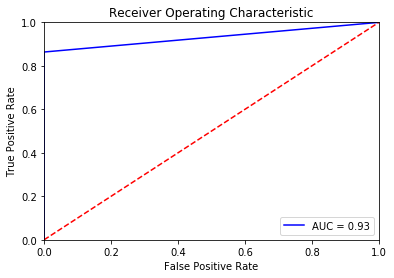

Classifier with C= 10
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.94      0.84      0.89        19

    accuracy                           0.87        30
   macro avg       0.86      0.88      0.86        30
weighted avg       0.88      0.87      0.87        30

[[10  1]
 [ 3 16]]
accuracy 86.66666666666667
roc_auc 0.8552036199095021


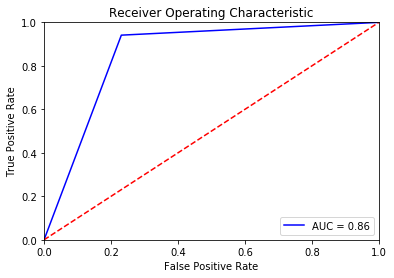

Classifier with C= 100
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      0.84      0.91        19

    accuracy                           0.90        30
   macro avg       0.89      0.92      0.90        30
weighted avg       0.92      0.90      0.90        30

[[11  0]
 [ 3 16]]
accuracy 90.0
roc_auc 0.8928571428571428


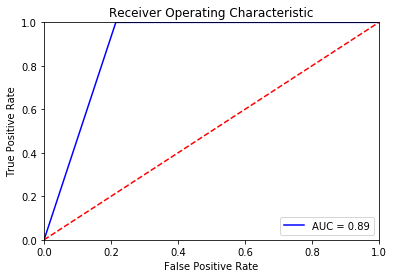

Classifier with C= 1000
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       1.00      0.79      0.88        19

    accuracy                           0.87        30
   macro avg       0.87      0.89      0.86        30
weighted avg       0.90      0.87      0.87        30

[[11  0]
 [ 4 15]]
accuracy 86.66666666666667
roc_auc 0.8666666666666667


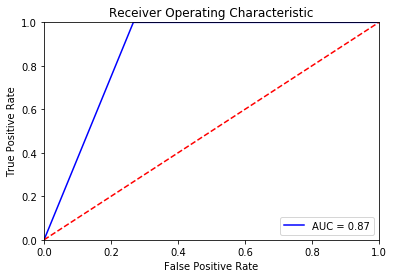

In [22]:

for c_value in [1, 10, 100, 1000]:
    print('Classifier with C=', c_value)
    idx += 1
    _run = trainer.new_run('C=' + str(c_value))
    # trainen van de logistic regression classifier
    logreg = linear_model.LogisticRegression(C=c_value,solver='liblinear')
    logreg.fit(X_train, y_train)
    
    trainer.evaluate_classifier(logreg, X_test, y_test, show_roc = True, upload_model = True)   

## Local experiment

In [10]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
ws = work_env.get_azureml_workspace()
exp = trainer.get_azureml_experiment()

In [11]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

dev-aiincubators-filip ComputeInstance Succeeded
dev-bart ComputeInstance Succeeded
dev-perrine ComputeInstance Succeeded
dev-bram ComputeInstance Succeeded
dev-sriram ComputeInstance Succeeded
dev-heavyduty ComputeInstance Succeeded
gpu-cluster AmlCompute Succeeded
cpu-cluster AmlCompute Succeeded
jupyter-gpu ComputeInstance Succeeded
gpu-cluster-1 AmlCompute Succeeded
gpu-cluster-4 AmlCompute Succeeded
gpu-cluster-2-2 AmlCompute Succeeded
gpu-cluster-2 AmlCompute Succeeded


In [12]:
from azureml.train.estimator import Estimator
from azureml.widgets import RunDetails


def get_training_script():
    # Copyright (c) Microsoft Corporation. All rights reserved.
    # Licensed under the MIT License.

    import argparse

    print("*********************************************************")
    print("Hello Azure ML!")

    parser = argparse.ArgumentParser()
    parser.add_argument('--numbers-in-sequence', type=int, dest='num_in_sequence', default=10,
                        help='number of fibonacci numbers in sequence')

    # This is how you can use a bool argument in Python. If you want the 'my_bool_var' to be True, just pass it
    # in Estimator's script_param as script+params:{'my_bool_var': ''}.
    # And, if you want to use it as False, then do not pass it in the Estimator's script_params.
    # You can reverse the behavior by setting action='store_false' in the next line.
    parser.add_argument("--my_bool_var", action='store_true')

    args = parser.parse_args()
    num = args.num_in_sequence
    my_bool_var = args.my_bool_var


    def fibo(n):
        if n < 2:
            return n
        else:
            return fibo(n - 1) + fibo(n - 2)


    try:
        from azureml.core import Run
        run = Run.get_context()
        print("The value of boolean parameter 'my_bool_var' is {}".format(my_bool_var))
        print("Log Fibonacci numbers.")
        run.
        for i in range(0, num - 1):
            run.log('Fibonacci numbers', fibo(i))
        run.complete()
    except:
        print("Warning: you need to install Azure ML SDK in order to log metrics.")

    print("*********************************************************")





import inspect
script_file_name = 'script_file.py'
lines = inspect.getsource(get_training_script)
lines = '\n'.join(lines.split('\n')[1:])
with open(script_file_name, "w") as script_file:
    script_file.write(lines)

In [15]:
from azureml.core.runconfig import RunConfiguration
run_local = RunConfiguration()
run_local.environment.python.user_managed_dependencies = True

In [16]:
from azureml.core import ScriptRunConfig, RunConfiguration, Experiment
from azureml.widgets import RunDetails
# run a trial from the train.py code in your current directory
config = ScriptRunConfig(source_directory='.', script=script_file_name, run_config = run_local)
script_run = exp.submit(config)
RunDetails(script_run).show()

#script_run.wait_for_completion(show_output = True)

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## Cloud compute training

In [19]:
from azureml.core.runconfig import RunConfiguration

from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.runconfig import DEFAULT_CPU_IMAGE
from azureml.core.script_run_config import ScriptRunConfig
default_compute = 'cpu-cluster'

# create a new runconfig object
run_cloud = RunConfiguration()

#default_compute_target = ws.get_default_compute_target(type="CPU")
#compute_target = ws.compute_targets[default_compute]
# signal that you want to use AmlCompute to execute script.
run_cloud.target = default_compute

# enable Docker 
run_cloud.environment.docker.enabled = True

# set Docker base image to the default CPU-based image
run_cloud.environment.docker.base_image = DEFAULT_CPU_IMAGE

# use conda_dependencies.yml to create a conda environment in the Docker image for execution
run_cloud.environment.python.user_managed_dependencies = False

# specify CondaDependencies obj
run_cloud.environment.python.conda_dependencies = CondaDependencies.create(conda_packages=['scikit-learn'])


In [21]:
from azureml.core import ScriptRunConfig, RunConfiguration, Experiment
from azureml.widgets import RunDetails
# run a trial from the train.py code in your current directory
config = ScriptRunConfig(source_directory='.', script=script_file_name, run_config = run_cloud)
script_run = exp.submit(config)
RunDetails(script_run).show()

#script_run.wait_for_completion(show_output = True)

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [22]:
type(type(str))

type